# Imports and Settings

In [1]:
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm
from laplace import Laplace
from utils.dataset import get_dataset
from utils.models import get_mlp
from utils.pytorch_learning import fit_map
from utils.metrics import *

In [2]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

In [3]:
torch.manual_seed(params["seed"])

In [4]:
dataset = get_dataset("Boston")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  363
Input dimension:  13
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


In [5]:
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MAP Learning

Baseline

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reconstruct the raw training targets from the normalized ones:
X_train = train_dataset.inputs
y_train = train_dataset.targets.ravel()

# For the test set, Test_Dataset stores raw targets already:
X_test  = test_dataset.inputs
y_test  = test_dataset.targets.ravel()

# Fit a default SVR
svr = SVR()  
svr.fit(X_train, y_train)

# Predict on test set
y_pred = svr.predict(X_test)

# Compute regression errors
mse_svr = mean_squared_error(y_test, y_pred)
mae_svr = mean_absolute_error(y_test, y_pred)

print(f"SVR Test MSE: {mse_svr:.4f}")
print(f"SVR Test MAE: {mae_svr:.4f}")


SVR Test MSE: 41.9504
SVR Test MAE: 3.6938


MLP

In [7]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=12000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=13, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training :   0%|          | 0/12000 [00:00<?, ? iteration/s]

Training : 100%|██████████| 12000/12000 [00:13<00:00, 913.09 iteration/s] 


In [8]:
import torch.nn.functional as F

f.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(params["device"], dtype=params["dtype"])
        yb = yb.to(params["device"], dtype=params["dtype"])
        preds = f(xb)
        all_preds.append(preds.cpu())
        all_targets.append(yb.cpu())

all_preds   = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

mse = F.mse_loss(all_preds, all_targets).item()
mae = F.l1_loss(all_preds, all_targets).item()

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test MSE: 19.8196
Test MAE: 2.8416


# Full LLA

In [9]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "full"
X = test_dataset.inputs
la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
la.fit(train_loader)

log_prior, log_sigma = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std = np.sqrt(1 / np.exp(log_prior.detach().numpy())).item()
log_variance = 2*log_sigma.detach().numpy().item()

100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


In [10]:
print("Optimal GP prior std: ", prior_std)
print("Optimal GP likelihoog log variance: ", log_variance)

Optimal GP prior std:  1.129085698104761
Optimal GP likelihoog log variance:  1.7355056087915255


In [11]:
train_dataset.inputs.shape

(363, 13)

In [ ]:
def distribution_plot(
    model_predictive,
    log_variance,
    feat: int = 0,
    name: str = None,
    batch_info: bool = False,
    Ngrid: int = 200,
):
    """
    Partial dependence style plot for a single feature `feat`.
    All other features are held at their train-set mean.
    """

    # Train arrays
    X_train = train_dataset.inputs      # (n_train, 13)
    y_train = train_dataset.targets.flatten()
    D       = X_train.shape[1]

    # Baseline for all other features (the mean across the training set)
    X_base = X_train.mean(axis=0)       # (13,)

    # Grid for feature `feat`
    x_min, x_max = X_train[:, feat].min(), X_train[:, feat].max()
    x_grid       = np.linspace(x_min, x_max, Ngrid)

    # Create X_grid of shape (Ngrid, 13)
    # each row is X_base except column feat is x_grid
    X_grid = np.tile(X_base, (Ngrid, 1))
    X_grid[:, feat] = x_grid

    # Predictive model
    inp = torch.tensor(X_grid, dtype=params["dtype"], device=params["device"])
    if batch_info:
        mean_t, var_t = model_predictive(inp, batch_size=batch_size)
    else:
        mean_t, var_t = model_predictive(inp)

    mean = mean_t.detach().cpu().numpy().flatten()
    var  = var_t.detach().cpu().numpy().flatten() + np.exp(log_variance)
    std  = np.sqrt(var)

    # Plot
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(12, 6))

    # Scatter the raw training points for that feature
    plt.scatter(
        X_train[:, feat],
        y_train,
        color="k",
        alpha=0.6,
        label="train data"
    )

    # Plot mean curve
    plt.plot(
        x_grid,
        mean,
        color="C0",
        lw=2,
        label="predictive mean"
    )

    # Shade +-2std
    plt.fill_between(
        x_grid,
        mean - 2*std,
        mean + 2*std,
        color="C0",
        alpha=0.2,
        label="±2 std"
    )

    plt.xlabel(f"Feature #{feat}")
    plt.ylabel("Housing value")
    plt.legend()
    plt.tight_layout()

    if name:
        plt.savefig(f"./plots/{name}.pdf", bbox_inches="tight")

    plt.show()


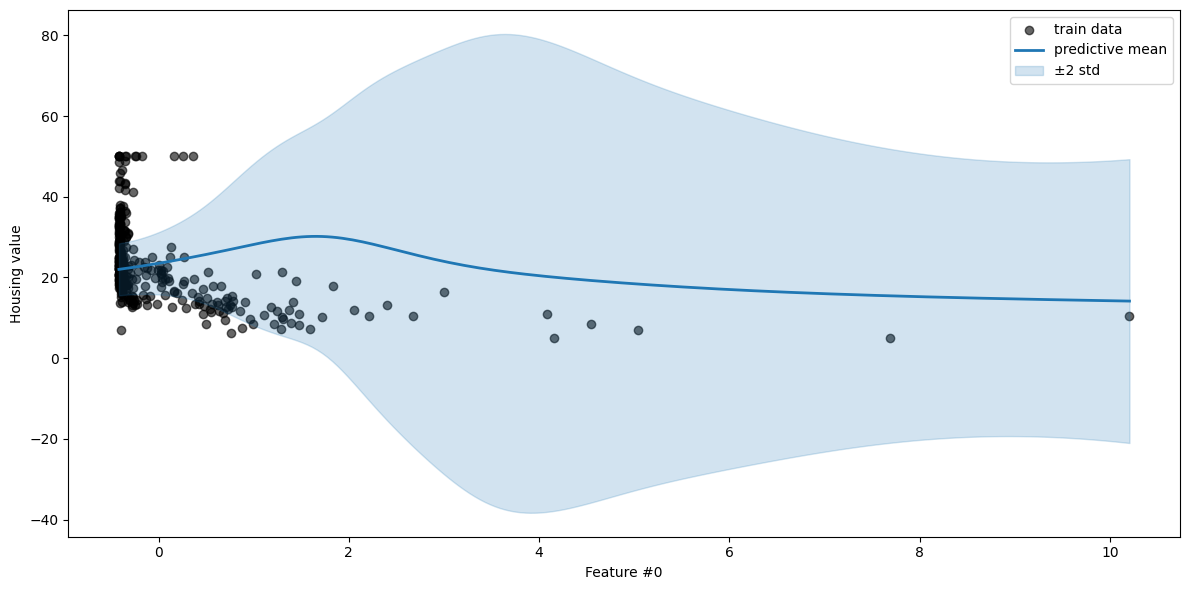

In [13]:
distribution_plot(la._glm_predictive_distribution, log_variance)

# Quadratic Laplace

In [14]:
# 'all', 'subnetwork' and 'last_layer'
subset = "all"
# 'full', 'kron', 'lowrank' and 'diag'
hessian = "quad"
quad_la = Laplace(f, "regression", subset_of_weights=subset, hessian_structure=hessian)
quad_la.fit(train_loader)

log_prior_quad, log_sigma_quad = torch.ones(1, requires_grad=True, dtype=params["dtype"]), torch.ones(
    1, requires_grad=True, dtype = params["dtype"]
)
hyper_optimizer = torch.optim.Adam([log_prior_quad, log_sigma_quad], lr=1e-1)
for i in tqdm(range(100)):
    hyper_optimizer.zero_grad()
    neg_marglik = -quad_la.log_marginal_likelihood(log_prior_quad.exp(), log_sigma_quad.exp())
    neg_marglik.backward()
    hyper_optimizer.step()

prior_std_quad = np.sqrt(1 / np.exp(log_prior_quad.detach().numpy())).item()
log_variance_quad = 2*log_sigma_quad.detach().numpy().item()

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [15]:
print("Optimal GP prior std: ", prior_std_quad)
print("Optimal GP likelihoog log variance: ", log_variance_quad)

Optimal GP prior std:  1.111258602311165
Optimal GP likelihoog log variance:  1.7764078478528607


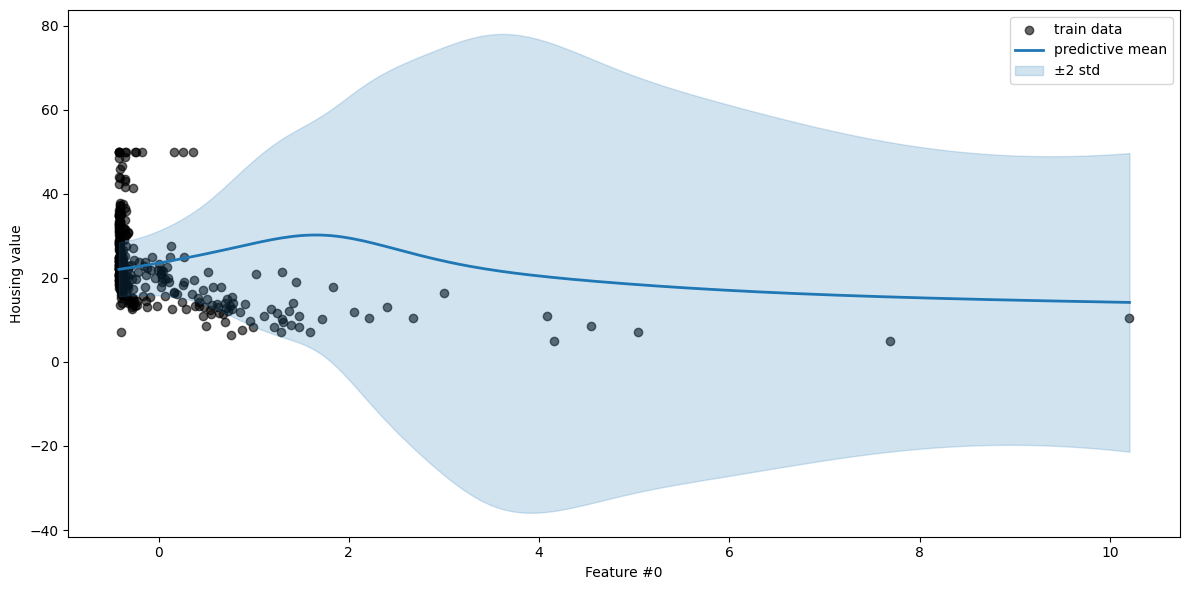

In [16]:
distribution_plot(quad_la._glm_predictive_distribution, log_variance_quad)

# Comparación

In [ ]:
def various_dist_plot(
    model1_predictive,
    model2_predictive,
    log_var1,
    log_var2,
    label1,
    label2,
    feat: int = 0,
    Ngrid: int = 200,
    name: str = None,
    batch_info1: bool = False,
    batch_info2: bool = False,
    noextra1: bool = False,
    noextra2: bool = False,
):
    """
    Compare two predictive distributions on feature `feat`.
    All other features fixed at their train-set mean.
    """
    # Train arrays & baseline
    X_train = train_dataset.inputs      # (n_train, D)
    y_train = train_dataset.targets.flatten()
    D       = X_train.shape[1]
    X_base  = X_train.mean(axis=0)      # (D,)

    # Grid along feature `feat`
    x_min, x_max = X_train[:, feat].min(), X_train[:, feat].max()
    x_grid       = np.linspace(x_min, x_max, Ngrid)
    X_grid       = np.tile(X_base, (Ngrid, 1))
    X_grid[:, feat] = x_grid

    # Model1
    inp1 = torch.tensor(X_grid, dtype=params["dtype"], device=params["device"])
    if batch_info1:
        m1, v1 = model1_predictive(inp1, batch_size=batch_size, noextra=noextra1)
    else:
        m1, v1 = model1_predictive(inp1)
    m1 = m1.detach().cpu().numpy().flatten()
    v1 = v1.detach().cpu().numpy().flatten() + np.exp(log_var1)
    s1 = np.sqrt(v1)

    # Model2
    inp2 = inp1  # same inputs
    if batch_info2:
        m2, v2 = model2_predictive(inp2, batch_size=batch_size, noextra=noextra2)
    else:
        m2, v2 = model2_predictive(inp2)
    m2 = m2.detach().cpu().numpy().flatten()
    v2 = v2.detach().cpu().numpy().flatten() + np.exp(log_var2)
    s2 = np.sqrt(v2)

    # Plot
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(12, 6))

    # scatter train data
    plt.scatter(
        X_train[:, feat],
        y_train,
        color="k",
        alpha=0.6,
        label="train data"
    )

    # predictive mean (they’re identical, so we just plot m1)
    plt.plot(
        x_grid,
        m1,
        color="k",
        lw=1.5,
        label="predictive mean"
    )

    # model1 band
    plt.fill_between(
        x_grid,
        m1 - 2*s1,
        m1 + 2*s1,
        color="C0",
        alpha=0.3,
        label=label1
    )

    # model2 band
    plt.fill_between(
        x_grid,
        m2 - 2*s2,
        m2 + 2*s2,
        color="C1",
        alpha=0.3,
        label=label2
    )

    plt.xlabel(f"Feature #{feat}")
    plt.ylabel("Target")
    plt.legend()
    plt.tight_layout()

    if name:
        plt.savefig(f"./plots/{name}.pdf", bbox_inches="tight")

    plt.show()


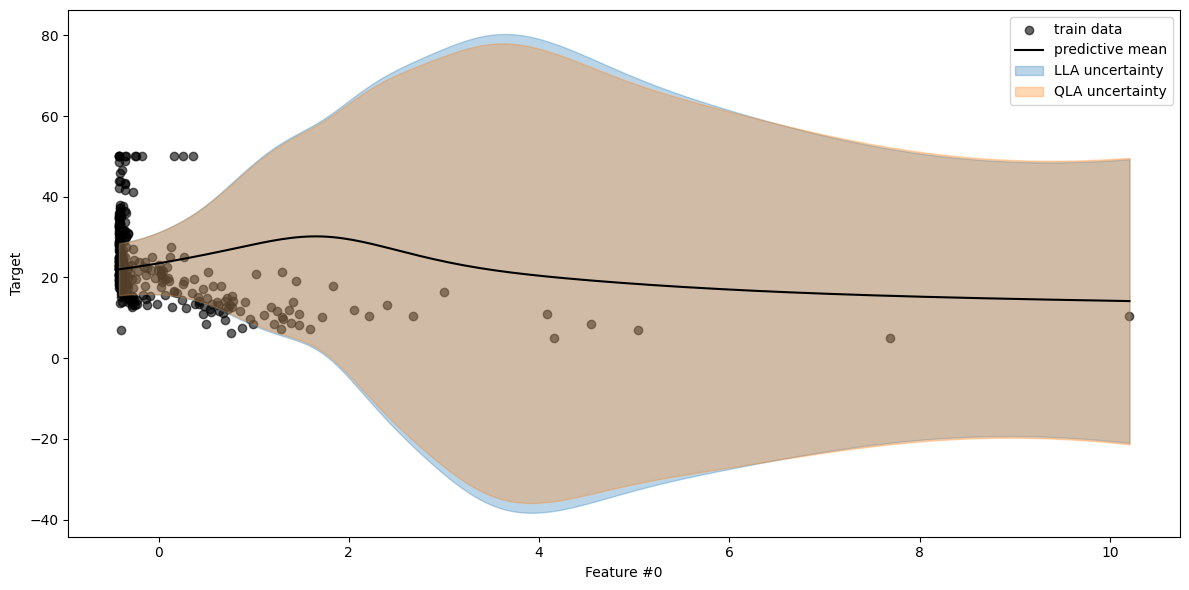

In [18]:
various_dist_plot(la._glm_predictive_distribution, quad_la._glm_predictive_distribution, log_variance, log_variance_quad, "LLA uncertainty", "QLA uncertainty")                

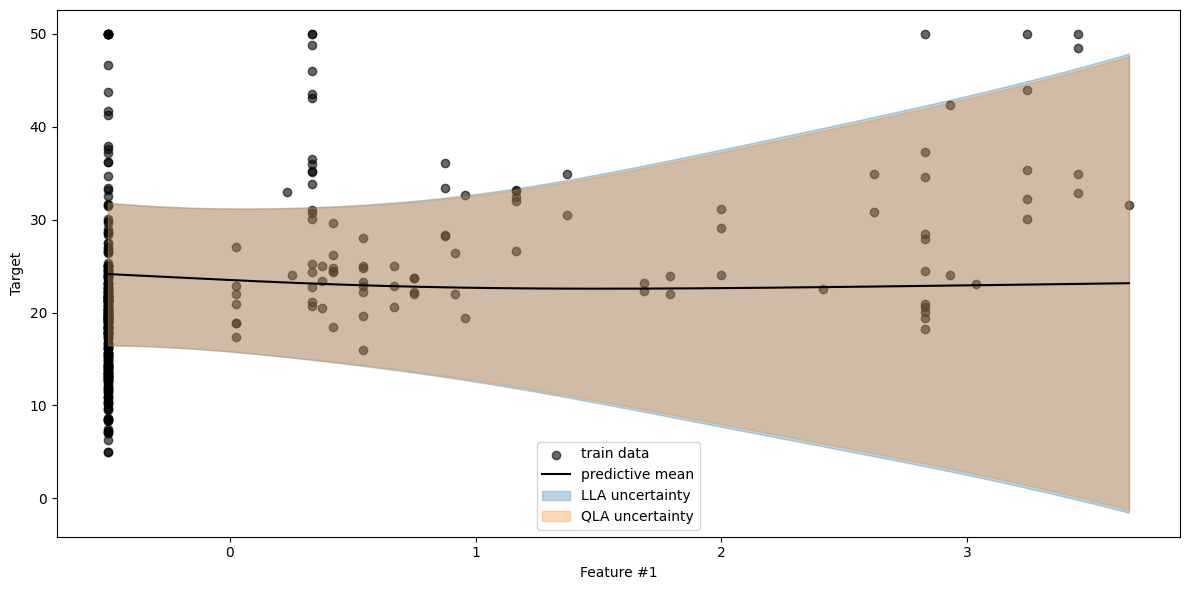

In [19]:
various_dist_plot(la._glm_predictive_distribution, quad_la._glm_predictive_distribution, log_variance, log_variance_quad, "LLA uncertainty", "QLA uncertainty", feat=1)                

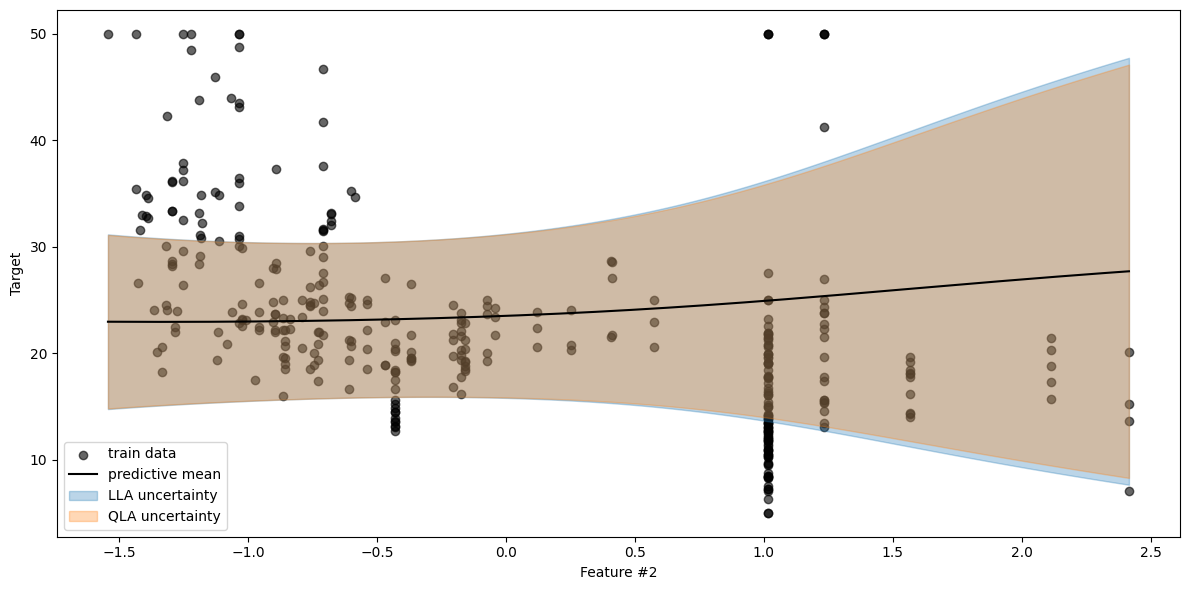

In [20]:
various_dist_plot(la._glm_predictive_distribution, quad_la._glm_predictive_distribution, log_variance, log_variance_quad, "LLA uncertainty", "QLA uncertainty", feat=2)                

# Métricas

In [29]:
mean_torch, var_torch = la._glm_predictive_distribution(
    torch.tensor(test_dataset.inputs, dtype=params["dtype"], device=params["device"])
)
mean_torch = mean_torch.detach()                  
var_torch  = var_torch.detach() + np.exp(log_variance)

y_true = torch.tensor(
    test_dataset.targets.flatten(),
    dtype=params["dtype"],
    device=params["device"]
)

lla_reg = Regression()
lla_reg.update(y_true, mean_torch, var_torch)

/home/pedrojgl/OneDrive/masterUAM/Investigación/Código/Proyecto/QuadraticLaplaceMethod/utils/metrics.py:93: UserWarning: Using a target size (torch.Size([102])) that is different to the input size (torch.Size([102, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.mse += torch.nn.functional.mse_loss(Fmean, y, reduction="sum")


In [30]:
lla_reg.get_dict()

{'RMSE': np.float64(116.59574375196928),
 'NLL': 2.7158651512570793,
 'Q-10': 669.5392156862745,
 'Q-20': 1289.0098039215686,
 'Q-30': 1878.9313725490197,
 'Q-40': 2441.2843137254904,
 'Q-50': 3004.6666666666665,
 'Q-60': 3573.401960784314,
 'Q-70': 4167.470588235294,
 'Q-80': 4812.176470588235,
 'Q-90': 5635.882352941177,
 'CQM': 2746.786274509804,
 'CRPS': 72653.61270662646}

In [33]:
mean_torch, var_torch = quad_la._glm_predictive_distribution(
    torch.tensor(test_dataset.inputs, dtype=params["dtype"], device=params["device"])
)
mean_torch = mean_torch.detach()                  
var_torch  = var_torch.detach() + np.exp(log_variance_quad)

y_true = torch.tensor(
    test_dataset.targets.flatten(),
    dtype=params["dtype"],
    device=params["device"]
)

qla_reg = Regression()
qla_reg.update(y_true, mean_torch, var_torch)

/home/pedrojgl/OneDrive/masterUAM/Investigación/Código/Proyecto/QuadraticLaplaceMethod/utils/metrics.py:93: UserWarning: Using a target size (torch.Size([102])) that is different to the input size (torch.Size([102, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.mse += torch.nn.functional.mse_loss(Fmean, y, reduction="sum")


In [34]:
qla_reg.get_dict()

{'RMSE': np.float64(116.59574375196928),
 'NLL': 2.7329958424419463,
 'Q-10': 667.0490196078431,
 'Q-20': 1286.6764705882354,
 'Q-30': 1874.1470588235295,
 'Q-40': 2440.4607843137255,
 'Q-50': 3004.323529411765,
 'Q-60': 3576.5,
 'Q-70': 4170.4607843137255,
 'Q-80': 4820.833333333333,
 'Q-90': 5646.823529411765,
 'CQM': 2748.2774509803926,
 'CRPS': 72578.05768605745}